In [2]:
import numpy as np 
import pandas as pd
import IPython
import seaborn as sns
import os 
import matplotlib.pyplot as plt

- Данная работа во многом основана серии статей https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504

# Constants

In [3]:
PATH = '/home/maksim/Data/voice_clf/'

TRAIN_PATH = os.path.join(PATH, 'train-clean-100/LibriTTS/train-clean-100/')
DEV_PATH = os.path.join(PATH, 'dev-clean/LibriTTS/dev-clean/')
TEST_PATH = os.path.join(PATH, 'test-clean/LibriTTS/test-clean/')

# EDA Speakers

In [14]:
data_speakers = pd.read_table(os.path.join(PATH, "train-clean-100/LibriTTS/speakers.tsv"), sep='\t')
data_speakers.head()

,READER,GENDER,SUBSET NAME
14,F,train-clean-360,Kristin LeMoine
16,F,train-clean-360,Alys AtteWater
17,M,train-clean-360,Gord Mackenzie
19,F,train-clean-100,Kara Shallenberg
20,F,train-other-500,Gesine


 <span style="font-size:6mm;"> Исправим порядок столбцов в data_speakers </span>

In [15]:
speakers = data_speakers.reset_index()
speakers.columns = ["READER", "GENDER", "SUBSET", "NAME"]
speakers.head()

,READER,GENDER,SUBSET,NAME
0,14,F,train-clean-360,Kristin LeMoine
1,16,F,train-clean-360,Alys AtteWater
2,17,M,train-clean-360,Gord Mackenzie
3,19,F,train-clean-100,Kara Shallenberg
4,20,F,train-other-500,Gesine


 <span style="font-size:6mm;">  Кодируем таргет</span>

In [16]:
speakers['is_M'] = (speakers["GENDER"] == "M") + .0

 <span style="font-size:6mm;"> Обработка пропусков  </span>

In [17]:
speakers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   READER  2484 non-null   int64  
 1   GENDER  2484 non-null   object 
 2   SUBSET  2484 non-null   object 
 3   NAME    2483 non-null   object 
 4   is_M    2484 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 97.2+ KB


- Для нашей задачи бинарной классификации голоса не принципиально наличие имени, главное, чтобы GENDER был указан

In [18]:
speakers[speakers['NAME'].isna()]

,READER,GENDER,SUBSET,NAME,is_M
32,60,M,train-clean-100,NaN,1.0


 <span style="font-size:6mm;"> Дубликатов нет </span>

In [19]:
speakers['READER'].unique().size == speakers['READER'].size

True

 <span style="font-size:6mm;">  Распределение по полам  </span>

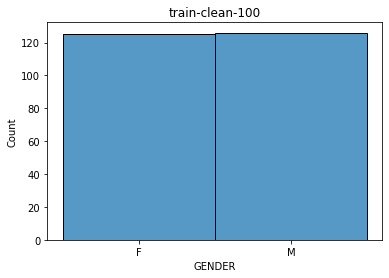

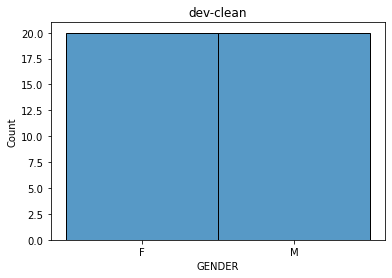

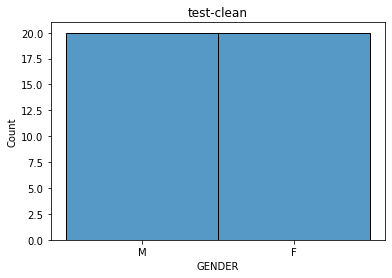

In [20]:
sns.histplot(x='GENDER', data=speakers[speakers['SUBSET'] == 'train-clean-100'])
plt.title("train-clean-100")
plt.show()

sns.histplot(x='GENDER', data=speakers[speakers['SUBSET'] == 'dev-clean'])
plt.title("dev-clean")
plt.show()

sns.histplot(x='GENDER', data=speakers[speakers['SUBSET'] == 'test-clean'])
plt.title("test-clean")
plt.show()

- Получили, что распределение пола в train/dev/test одинаковое - Отлично! 

# Считаем данные

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import librosa

In [22]:
rng = np.random.default_rng(seed=42)

train_files = np.array(list(Path(TRAIN_PATH).rglob('*/*/*.wav')))
dev_files =  np.array(list(Path(DEV_PATH).rglob('*/*/*.wav')))
test_files = np.array(list(Path(TEST_PATH).rglob('*/*/*.wav')))

rng.shuffle(train_files)
rng.shuffle(dev_files)
rng.shuffle(test_files)

## Создадим таргет

In [23]:
dict_reader_to_gender =  pd.Series(speakers.is_M.values, index=speakers.READER).to_dict() 

In [24]:
# int(file.parts[-3]) - номер диктора
y_train = np.array([dict_reader_to_gender[int(file.parts[-3])] for file in train_files])
y_dev = np.array([dict_reader_to_gender[int(file.parts[-3])] for file in dev_files])
y_test = np.array([dict_reader_to_gender[int(file.parts[-3])] for file in test_files])

# Пример звуковой дорожки

In [25]:
import librosa
import librosa.display

In [26]:
example_audio = train_files[12]
samples, sample_rate = librosa.load(example_audio, sr=None)

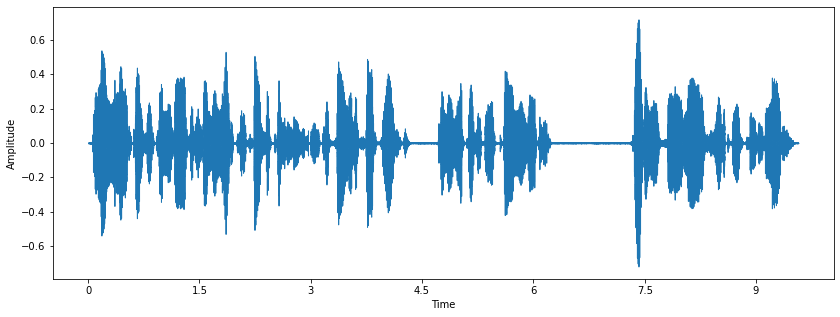

In [27]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(samples, sr=sample_rate)
plt.ylabel("Amplitude")
plt.show()

- Из сырых данных (Амплитуда vs время) слишком сложно извлечь информацию, нужна обработка 

In [28]:
from IPython.display import Audio
Audio(example_audio)

In [29]:
print('Example shape ', samples.shape, 'Sample rate ', sample_rate, 'Data type', type(samples))
print(samples[22400:22420])

Example shape  (229680,) Sample rate  24000 Data type <class 'numpy.ndarray'>
[-0.03277588 -0.04324341 -0.02175903  0.00073242  0.02609253  0.05023193
  0.05535889  0.00598145 -0.0690918  -0.07138062 -0.03060913  0.03445435
  0.06225586  0.06253052  0.04620361 -0.02505493 -0.06976318 -0.06759644
 -0.02056885  0.04980469]


# Spectrograms

- Применяем Short-time Fourier transform к звуковой дорожке  
- Переходим к синусным частотом сигнала в локальных окнах

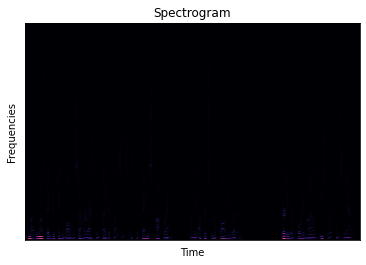

In [30]:
sgram = np.abs(librosa.stft(samples))
librosa.display.specshow(sgram)
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequencies")
plt.show()

In [31]:
sgram.shape

(1025, 449)

- Получили картинку с малым количеством информации 
- Проблема в линейности, люди воспринимают звук логарифмически 

## Mel Spectrograms

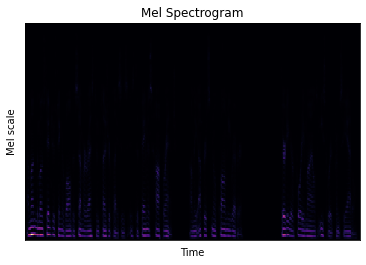

In [32]:
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
librosa.display.specshow(mel_scale_sgram)
plt.title("Mel Spectrogram")
plt.xlabel("Time")
plt.ylabel("Mel scale")
plt.show()

- По горизонтальной шкале отложено время, по вертикальной Mel scale = $2595 log_{10}\left(1 + \frac{f}{700}\right)$, где f - частота
- Будем отмечать цветом децебелы, а не аплитуду:

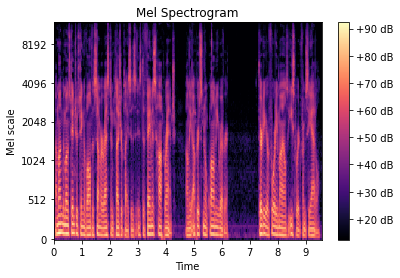

In [33]:
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title("Mel Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.ylabel("Mel scale")
plt.show()

In [34]:
print(f"mel_sgram.shape = {mel_sgram.shape}")

mel_sgram.shape = (128, 449)


- Получили насыщенную картинку, которую можно использовать в CNN
- Можем получить более компактное представление с помощью MFCC

## MFCC 

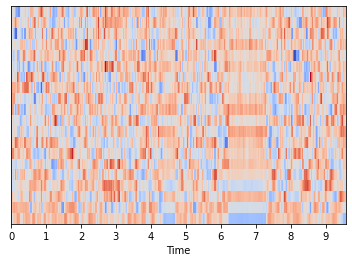

In [35]:
import sklearn
import librosa
import librosa.display

# Load the audio file
samples, sample_rate = librosa.load(example_audio, sr=None)
mfcc = librosa.feature.mfcc(y=samples, sr=sample_rate)

# Center MFCC coefficient dimensions to the mean and unit variance
mfcc = sklearn.preprocessing.scale(mfcc.astype(float), axis=1)
librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')
plt.show()

In [36]:
print (f'MFCC is of type {type(mfcc)} with shape {mfcc.shape}')

MFCC is of type <class 'numpy.ndarray'> with shape (20, 449)


- Дополнительно обработали Мел спектограмму, получив более компактное представление 
- Стоит ли использовать в нашей задаче?

# Sound preprocessing

Необходимо, чтобы:
1. У аудиофайлов был одинаковый sampling rate (The audio files are at 24kHz sampling rate;)
2. У аудиофайлов было одинаковое число каналов 
3. У аудиофайлов должна быть одинаковая длительность 

Что будем делать:
1. Из документации нам известно, что первый пункт выполнен (The audio files are at 24kHz sampling rate;)
2. Исходные данные стандартизированы, поступают в одном канале
3. Средняя длина аудиодорожки равна 6 секундам, будем обраезать/дополнять тишиной

In [70]:
import torchaudio
import torch

long_audio =  torchaudio.load(train_files[1040])
short_audio = torchaudio.load(train_files[0])
max_seconds = 6

In [71]:
Audio(train_files[1040])

In [72]:
Audio(train_files[0])

In [73]:
def get_len_sample(audio):
    sample, sampling_rate = audio
    return sample.shape[1] / sampling_rate

def pad_trunc(audio, max_seconds):
    signal, sampling_rate = audio
    num_rows, sig_len = signal.shape
    max_len = sampling_rate * max_seconds
    if sig_len > max_len:
        signal = signal[:, :max_len]
    elif sig_len < max_len:
        # Length of padding to add at the beginning and end of the signal
        pad_begin_len = np.random.randint(0, max_len - sig_len)
        pad_end_len = max_len - sig_len - pad_begin_len
        # Pad with 0s
        pad_begin = torch.zeros((num_rows, pad_begin_len))
        pad_end = torch.zeros((num_rows, pad_end_len))
        signal = torch.cat((pad_begin, signal, pad_end), 1)
    return signal, sampling_rate

In [74]:
pad_trunc_long = pad_trunc(long_audio, max_seconds)
pad_trunc_short = pad_trunc(short_audio, max_seconds)

In [75]:
get_len_sample(pad_trunc_long), get_len_sample(pad_trunc_short)

(6.0, 6.0)

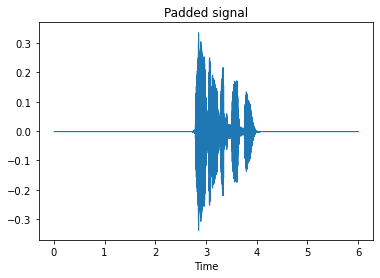

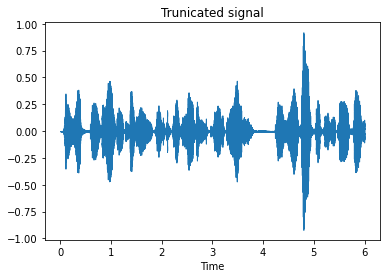

In [76]:
librosa.display.waveshow(pad_trunc_short[0].numpy(), sr=pad_trunc_short[1])
plt.title("Padded signal")
plt.show()
librosa.display.waveshow(pad_trunc_long[0].numpy(), sr=pad_trunc_long[1])
plt.title("Trunicated signal")
plt.show()

# Data Augmentation

In [ ]:
length = []
for path in train_files[:2000]:
    samples, sample_rate = librosa.load(path, sr=None)
    length.append(len(samples)/ sample_rate)

In [ ]:
print(f"Средняя длина аудиодорожки = {round(np.mean(length),1)} секунд")

## Noise

In [77]:
def add_noise(audio):
    signal, sampling_rate = audio
    _, sig_len = signal.shape
    signal = signal + np.random.uniform(-0.05, 0.05, sig_len)
    return signal, sampling_rate

In [78]:
noised_audio = add_noise(long_audio)

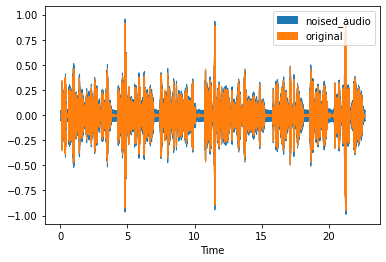

In [79]:
librosa.display.waveshow(noised_audio[0].numpy(), sr=noised_audio[1], label="noised_audio")
librosa.display.waveshow(long_audio[0].numpy(), sr=long_audio[1], label="original")
plt.legend()
plt.show()

... to be done

## Пример итогового преобразования

In [15]:
from data_loader import Loader

loader = Loader(PATH)
train_dl, dev_dl, test_dl = loader.load_dataset()

In [66]:
X_batch, y_batch = next(iter(train_dl))

In [54]:
X_batch.shape

torch.Size([16, 1, 64, 282])

In [17]:
import librosa
import librosa.display

def plot_spectrogram(X_batch, i):
    librosa.display.specshow(np.abs(X_batch[i,0,:,:].numpy()), sr=24000, x_axis='time', y_axis='mel')
    plt.title("Mel Spectrogram")
    plt.colorbar(format='%+2.0f dB')
    plt.ylabel("Mel scale")
    plt.show()
    

Male


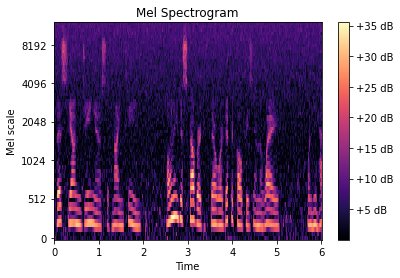

Male


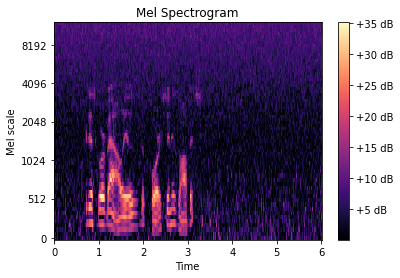

Female


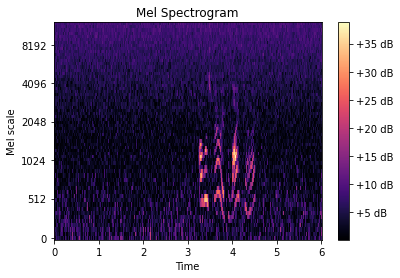

In [18]:
for i in range(3):
    print("Male" if y_batch[i] == 1  else "Female")
    plot_spectrogram(X_batch, i)


# Baseline model

In [8]:
from model import AudioClassifier
import torch

clf_path = PATH + "baseline.pth"
baseline = AudioClassifier()
baseline.load_state_dict(torch.load(clf_path))

<All keys matched successfully>

Используем архитектуру:
- Conv2d -> MaxPool2d -> ReLU -> BatchNorm2d ->
-  -> Conv2d -> MaxPool2d -> ReLU -> BatchNorm2d ->
- ->  Linear -> ReLU -> Linear -> Sigmoid

num_epoch = 5

In [9]:
print(baseline)

AudioClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=816, out_features=300, bias=True)
  (relu3): ReLU()
  (lin2): Linear(in_features=300, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [10]:
from torchsummary import summary

summary(baseline, (1, 64, 282))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 32, 141]             208
            Conv2d-2           [-1, 8, 32, 141]             208
         MaxPool2d-3            [-1, 8, 15, 70]               0
         MaxPool2d-4            [-1, 8, 15, 70]               0
              ReLU-5            [-1, 8, 15, 70]               0
              ReLU-6            [-1, 8, 15, 70]               0
       BatchNorm2d-7            [-1, 8, 15, 70]              16
       BatchNorm2d-8            [-1, 8, 15, 70]              16
            Conv2d-9            [-1, 16, 8, 35]           1,168
           Conv2d-10            [-1, 16, 8, 35]           1,168
        MaxPool2d-11            [-1, 16, 3, 17]               0
        MaxPool2d-12            [-1, 16, 3, 17]               0
             ReLU-13            [-1, 16, 3, 17]               0
             ReLU-14            [-1, 16

In [13]:
from data_loader import Loader
from training import test_model

loader = Loader(PATH)
train_dl, dev_dl, test_dl = loader.load_dataset()

accuracy = test_model(dev_dl, baseline)

In [14]:
accuracy

tensor(91.4052)

- Accuracy на train =  96.41
- Accuracy на val = 91.4

*Видим некоторое переобучение. Модель показывает достаточно хорошую точность на train, так что не будем ее усложнять.*
*В целом, усложнить можно, но прирост в 1-2 % не является целью данной работы, особенно, если итерироваться по идеям будет намного дольше. Я так представляю, что 98-99 процетов будет теоретическим максимумом точности, поскольку бывают случаи, когда даже человеку сложно отличить голос*

*Идеи по улучшению:*
- Попробуем поставить Batch слой перед RELU, а не после 
- Попробуем использовать MFCC вместо Mel Spectrogram
- Попробуем добавить дропаут 
- Попробуем добавить Spec Augment

# Baseline but Batch before RELU

In [23]:
from model import AudioClassifier
import torch

clf_path = PATH + "batch_before_relu.pth"
model = AudioClassifier()
model.load_state_dict(torch.load(clf_path))

<All keys matched successfully>

In [42]:
model

AudioClassifier(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=816, out_features=300, bias=True)
  (lin2): Linear(in_features=300, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(8

In [40]:
from training import test_model
from data_loader import Loader


loader = Loader(PATH)
train_dl, dev_dl, test_dl = loader.load_dataset()
accuracy = test_model(dev_dl, model)

In [41]:
accuracy

tensor(91.7887)

- Accuracy на train =  97.37
- Accuracy на val = 91.79

*Отлично, видим прирост в accuracy как на train, так и на val*

# Use MFCC instead of Mel Spectogram

In [37]:
from audio_utils import AudioUtil
import torchaudio
from torchaudio import transforms
from data_loader import Loader

util = AudioUtil()

In [61]:
example_audio = torchaudio.load(train_files[18])

In [62]:
sig, sr = example_audio
mfcc = transforms.MFCC(sample_rate=sr, norm='ortho')(sig)

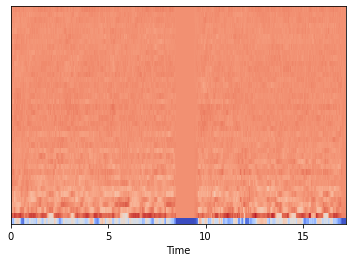

In [64]:
librosa.display.specshow( mfcc.numpy()[0,:,:].astype(float), sr=sample_rate, x_axis='time')
plt.title("Mel Spectrogram")
plt.show()

In [73]:
from model import AudioClassifier
import torch

clf_path = PATH + "MFCC_instead_of_Mel.pth"
model = AudioClassifier()
model.load_state_dict(torch.load(clf_path))

<All keys matched successfully>

In [74]:
from training import test_model
from data_loader import Loader


loader = Loader(PATH)
train_dl, dev_dl, test_dl = loader.load_dataset()
accuracy = test_model(dev_dl, model)

In [75]:
accuracy

tensor(90.3243)

- Accuracy на train =  96.96
- Accuracy на val = 90.32

*Видим, что Accuracy при использовании MFCC ниже как на train, так и на val. Будем использовать Mel Spectogram*

# Add Dropout Layer

Используем архитектуру:
- Conv2d -> MaxPool2d -> ReLU -> BatchNorm2d ->
-  -> Conv2d -> MaxPool2d -> ReLU -> BatchNorm2d ->
- ->  Linear -> ReLU -> DROPOUT -> Linear -> Sigmoid

# Augment the Spectrogram 

# SOTA решение 

## Статья "Age and gender recognition using a convolutional neural network with a specially designed multi-attention module through speech spectrograms" 2021

- Accuracy = 96% на датасете  Common Voice dataset

**Сама модель:**

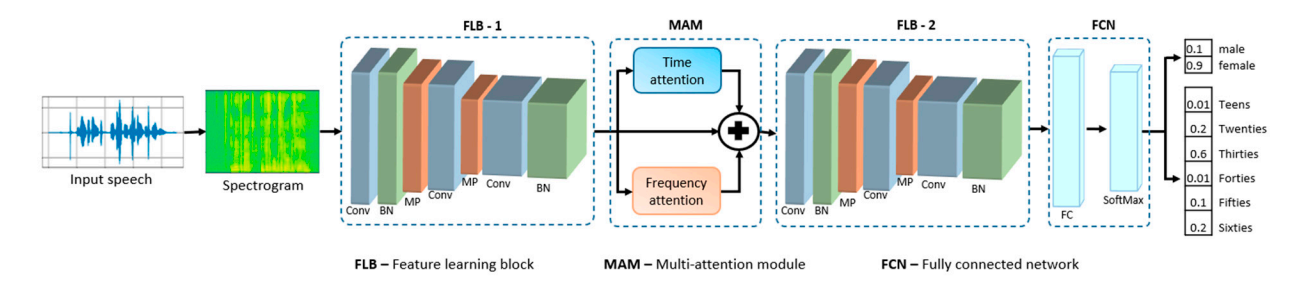

Отличия от Baseline:
- Используют 3 CONV слоя в каждом из двух блоков
- Используют один FC слой
- Используют Multi-Attention механизм, включающий skip-connection

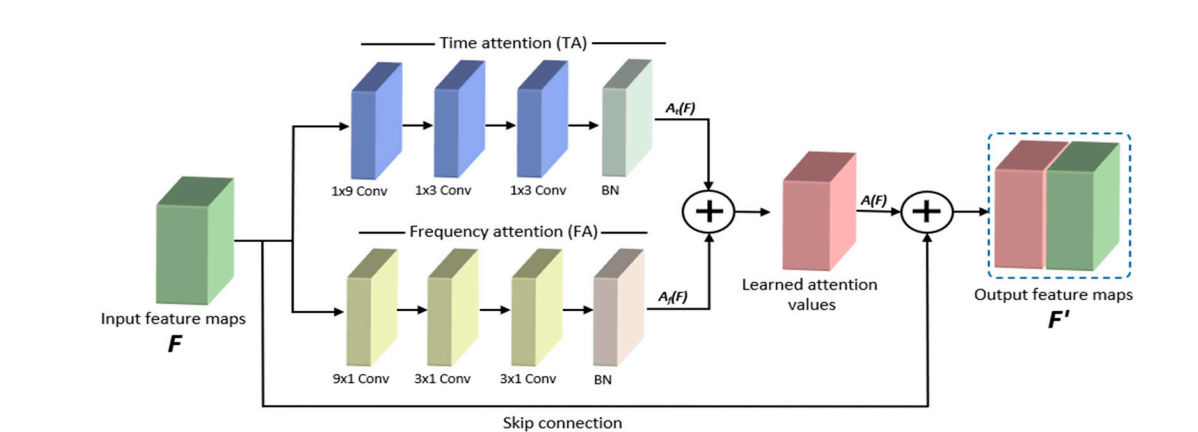

Идеи для дальнейшней работы
- Применить Multi-Attention блок
- Настроить параметры Mel Spectrogram?
- 